## Домашнее задание №4
### Deadline - 14 November 23:59

Данное задание посвящено семантической сегментации. Ваша цель реализовать модель сегментации cпутниковых снимков на датасете [FloodNet Challenge](http://www.classic.grss-ieee.org/earthvision2021/challenge.html).. В первой части задания вы реализуете основные инструменты, которые необходимы для задачи сегментации: подсчет метрик, архитектуры, логгирование метрик. Во второй части вам предложено улучшить текущее решение и выбить заданные скор на задаче, используя любые трюки/идеи, которые вы сможете реализовать

## Часть 1: Базовое решение (1/3 от максимального числа баллов)
- Подсчет метрик
- Архитектуру модели (реализовать UNet)
- Обучение модели

### Loading dataset

In [1]:
# !gdown --id 1vLTGoRO1zeQSZ0mfRTgVC9W6R5Z94UoO

Распаковываем архив

In [2]:
# !tar -xzf tiny-floodnet-challenge.tar.gz

In [3]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor, PILToTensor, Compose

### Dataset

Датасет уже содержит разбиение на обучающую и тестовые выборки

In [4]:
import glob
import os
import numpy as np
import albumentations as A

from PIL import Image

Для обработки изображений будем использовать библиотеку [albumentations](https://albumentations.ai/docs/). В ней содержиться больше аугментаций чем в torchvision, а также реализовано более удобная работа с аугментациями.

Реализуйте загрузку данных

In [55]:
class FloodNet(Dataset):
    """
    Классы:
    0: Background, 1: Building, 2: Road, 3: Water, 4: Tree, 5: Vehicle, 6: Pool, 7: Grass
    """
    def __init__(
        self,
        data_path: str,
        phase: str,
        augment: bool,
        img_size: int,
    ):
        self.num_classes = 8
        self.data_path = data_path
        self.phase = phase
        self.augment = augment
        self.img_size = img_size

        self.items = [filename.split('.')[0] for filename in os.listdir(f'{data_path}/{phase}/image')]

        if augment:
            self.transform = A.Compose([
                                        A.HorizontalFlip(p=0.5),
                                        A.VerticalFlip(p=0.5),
                                        A.Normalize(),
                                        A.RandomResizedCrop(width=img_size, height=img_size, 
                                                            scale=[0.8,1.0], ratio=(1,1), p=0.9),
                                        A.Resize(height=img_size, width=img_size)
                                        ])          
        else:
            #A.geometric.resize.Resize
            self.transform = A.Compose([
                                    A.Normalize(),
                                    A.Resize(height=img_size, width=img_size)
                                    ])

        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        image = np.asarray(Image.open(f'{self.data_path}/{self.phase}/image/{self.items[index]}.jpg'))
        mask = np.asarray(Image.open(f'{self.data_path}/{self.phase}/mask/{self.items[index]}.png'))

        # if self.phase == 'train':
        # 	# TODO: apply transform to both image and mask (0.5 points)
        augmented = self.transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

        image = self.to_tensor(image.copy())
        mask = torch.from_numpy(mask.copy()).long()

        if self.phase == 'train':
            assert isinstance(image, torch.FloatTensor) and image.shape == (3, self.img_size, self.img_size)
            assert isinstance(mask, torch.LongTensor) and mask.shape == (self.img_size, self.img_size)

        return image, mask

In [56]:
NUM_CLASSES=8

In [57]:
train_dataset = FloodNet('tiny-floodnet-challenge', 'train', True, 256)
test_dataset = FloodNet('tiny-floodnet-challenge', 'test', False, 256)

Берем небольшой батч, так как иначе изображения не поместятся в память

In [58]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Metrics

Мы закончили с реализацией датасета. Теперь необходимо реализовать подсчет IoU, Recall, Accuracy

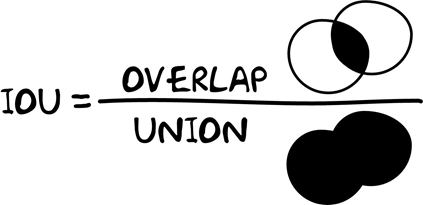

In [59]:
for img, m in train_dataloader:
    print(img.shape, m.shape)
    break
for img, m in val_dataloader:
    print(img.shape, m.shape)
    break

torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])


In [60]:
def calc_val_data(preds, masks, num_classes):
    # batch_size x num_classes x H x W
    preds = torch.argmax(preds, dim=1)
    batch_size=preds.shape[0]

    preds_per_class = torch.cat([preds.unsqueeze(1) == i for i in range(num_classes)],1)
    masks_per_class = torch.cat([masks.unsqueeze(1) == i for i in range(num_classes)],1)
    intersection = torch.sum(preds_per_class * masks_per_class, dim=[2,3])
    union = torch.sum(preds_per_class + masks_per_class, dim=[2,3])
    target = torch.sum(masks_per_class, dim=[2,3])

    # for i in range(num_classes): # Go over all classes
    #     # TODO

    assert isinstance(intersection, torch.Tensor), 'Output should be a tensor'
    assert isinstance(union, torch.Tensor), 'Output should be a tensor'
    assert isinstance(target, torch.Tensor), 'Output should be a tensor'

    assert intersection.shape == union.shape == target.shape, 'Wrong output shape'
    assert union.shape[0] == masks.shape[0] and union.shape[1] == num_classes, 'Wrong output shape'

    return intersection, union, target

$mean IoU = \frac{1}{|classes|} \sum_{i=1}^{|classes|} IoU(class)$

In [61]:
# def calc_val_loss(intersection, union, target, eps = 1e-7):
#     # average over classes
#     mean_iou = torch.mean(intersection/(union+eps))
#     mean_class_rec = ... # TODO: calc mean class recall
#     mean_acc = ... # TODO: calc mean accuracy

#     return mean_iou, mean_class_rec, mean_acc

Обновленные метрики от Матвея

In [62]:
def iou(net_output, target, class_label=torch.tensor(1).type(torch.int), eps=1e-6):
    net_out_ = (net_output == class_label)
    target_ = (target == class_label)
    return (torch.sum(net_out_ * target_))/(torch.sum(torch.maximum(net_out_, target_)) + eps)

def recall(net_output, target, class_label=torch.tensor(1).type(torch.int), eps=1e-6):
    net_out_ = (net_output == class_label)
    target_ = (target == class_label)
    return (torch.sum(net_out_ * target_))/(torch.sum(target_) + eps)

def accuracy(net_output, target, class_label=torch.tensor(1).type(torch.int), eps=1e-6):
    net_out_ = (net_output == class_label)
    target_ = (target == class_label)
    return (torch.sum(net_out_ == target_))/(torch.sum(torch.ones_like(target_)) + eps)

def calc_val_loss(outputs, masks, num_classes, eps=1e-7):
    softmax     = torch.nn.Softmax(dim=1)
    probability = softmax(outputs)
    prediction  = torch.argmax(probability, dim=1)
    mean_iou, mean_recall, mean_acc = [], [], []

    ind = [i for i in range(num_classes) if (masks==i).sum() > 0]
    for i in ind:
        mean_iou.append(iou(prediction, masks, i, eps=eps).item())
        mean_recall.append(recall(prediction, masks, i, eps=eps).item())
        mean_acc.append(accuracy(prediction, masks, i, eps=eps).item())
    return np.mean(mean_iou), np.mean(mean_recall), np.mean(mean_acc)

### Model

В качестве базовой модели будем использовать UNet. Архитектура представлена ниже. Вам не нужно точно воспроизвести архитектуру. Важно реализовать передачу intermediate features, полученные от encoder к decoder.

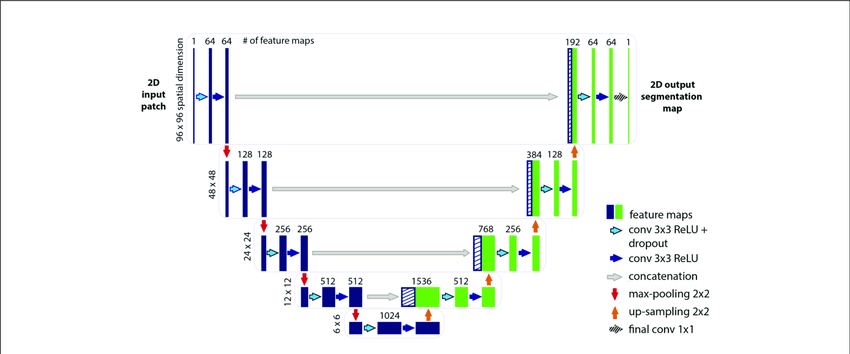

In [63]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models

# class DownBlock(nn.Module):
#     def __init__(self, in_channel, out_channel, down=True):
#         super().__init__()
#         # TODO

#     def forward(self, x):
#         # TODO
#         return x

In [64]:
# class UpBlock(nn.Module):
#     def __init__(self, in_channel, prev_channel, out_channel, up=True):
#         super().__init__()
#         # TODO

#     def forward(self, x, res=None):
#         # TODO
#         return x

#### Реализация через такие блоки неудобная, предлагаю свою:

In [65]:
class Block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, stride=1, 
                 padding=1, normalize=True, dropout=False):
        super().__init__()
        self.norm = normalize
        self.dropout = nn.Dropout(p=dropout) if dropout else False
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.dropout(out) if self.dropout else out
        out = F.layer_norm(out, out.shape) if self.norm else out
        out = self.conv2(out)
        out = self.activation(out)
        out = F.layer_norm(out, out.shape) if self.norm else out
        return out

In [66]:
class UNet(nn.Module):
    """
    Используя UpBlock и DownBlock, реализуйте полноценную архитектуру.
    Учтите, что разрешение изображение может не делиться на 2**num_down_blocks, поэтому
    вам нужно интерполировать его до нужного разрешения

    Для уменьшения/увеличения размерности можете использовать любой удобный вам метод
    """
    def __init__(self,
                 num_classes,
                 width=256,
                 height=256,
                 in_channels=3,
                 dropout=0.2,
                 depth=32):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # First half
        self.b1 = nn.Sequential(
            Block(in_channels, depth, dropout=False),
            Block(depth, depth, dropout=False)
        )
        # self.down1 = nn.MaxPool2d(2, 2)
        self.down1 = nn.Conv2d(depth, depth*2, kernel_size=2, stride=2)
        
        self.b2 = nn.Sequential(
            # Block(depth, depth*2, dropout=False),
            Block(depth*2, depth*2, dropout=dropout),
            Block(depth*2, depth*2, dropout=False)
        )
        #self.down2 = nn.MaxPool2d(2, 2)
        self.down2 = nn.Conv2d(depth*2, depth*4, kernel_size=2, stride=2)

        self.b3 = nn.Sequential(
            # Block(depth*2, depth*4, dropout=False),
            Block(depth*4, depth*4, dropout=dropout),
            Block(depth*4, depth*4, dropout=False)
        )
        # self.down3 = nn.MaxPool2d(2, 2)
        self.down3 = nn.Conv2d(depth*4, depth*8, kernel_size=2, stride=2)

        self.b4 = nn.Sequential(
            # Block(depth*4, depth*8, dropout=False),
            Block(depth*8, depth*8, dropout=dropout),
            Block(depth*8, depth*8, dropout=False)
        )
        # self.down4 = nn.MaxPool2d(2, 2)
        self.down4 = nn.Conv2d(depth*8, depth*16, kernel_size=2, stride=2)

        # Bottleneck
        self.b_mid = nn.Sequential(
            # Block(depth*8, depth*16, dropout=False),
            Block(depth*16, depth*16, dropout=dropout),
            Block(depth*16, depth*16, dropout=False)
        )
        
        # Second half
        self.up1 = nn.ConvTranspose2d(depth*16, depth*8, 2, 2)
        self.b5 = nn.Sequential(
            Block(depth*16, depth*8, dropout=dropout),
            Block(depth*8, depth*8, dropout=False),
        )

        self.up2 = nn.ConvTranspose2d(depth*8, depth*4, 2, 2)
        self.b6 = nn.Sequential(
            Block(depth*8, depth*4, dropout=dropout),
            Block(depth*4, depth*4, dropout=False),
        )

        self.up3 = nn.ConvTranspose2d(depth*4, depth*2, 2, 2)
        self.b7 = nn.Sequential(
            Block(depth*4, depth*2, dropout=dropout),
            Block(depth*2, depth*2, dropout=False),
        )

        self.up4 = nn.ConvTranspose2d(depth*2, depth, 2, 2)
        self.b8 = nn.Sequential(
            Block(depth*2, depth, dropout=dropout),
            Block(depth, depth, dropout=False),
        )

        self.conv_out = nn.Conv2d(depth, num_classes, 1)
        

    def forward(self, inputs):
        out1 = self.b1(inputs)
        out2 = self.b2(self.down1(out1))
        out3 = self.b3(self.down2(out2))
        out4 = self.b4(self.down3(out3))

        out_mid = self.b_mid(self.down4(out4))

        out5 = torch.cat((out4, self.up1(out_mid)), dim=1)
        out5 = self.b5(out5)
        out6 = torch.cat((out3, self.up2(out5)), dim=1)
        out6 = self.b6(out6)
        out7 = torch.cat((out2, self.up3(out6)), dim=1)
        out7 = self.b7(out7)
        out8 = torch.cat((out1, self.up4(out7)), dim=1)
        out8 = self.b8(out8)

        logits = self.conv_out(out8)

        assert logits.shape == (inputs.shape[0], self.num_classes, inputs.shape[2], inputs.shape[3]), 'Wrong shape of the logits'
        return logits

### Training

In [68]:
import gc

device='cuda:0'
try:
    del m, optim, scheduler, pred, x, y, loss
except: pass
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

m = UNet(NUM_CLASSES, depth=64, dropout=0.15).to(device)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

grad_accum = 20
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(m.parameters(), lr=2e-4, betas=(0.8, 0.9))
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)
tb = SummaryWriter()


global_step = 0
for epoch in tqdm(range(100), colour="#449944"):
    m.train()
    optim.zero_grad()
    
    for i, batch in enumerate(tqdm(train_dataloader, colour="#444499", leave=False, desc=f"Train")):
        x, y = batch[0].to(device), batch[1].to(device)
        pred = m(x)
        loss = criterion(pred, y)

        tb.add_scalar("train_loss", loss.item(), global_step)
        global_step += 1
        loss.backward()
        
        if (i+1) % grad_accum == 0 or i == len(train_dataloader) - 1:
            optim.step()    
            optim.zero_grad()
            
    scheduler.step()

    intersection, union, target = 0.0, 0.0, 0.0
    with torch.no_grad():
        outputs = []
        masks = []
        m.eval()
        for batch in tqdm(val_dataloader, colour="#227777", leave=False, desc=f"Eval"):
            x, y = batch[0].to(device), batch[1].to(device)
            pred = m(x)

            loss = criterion(pred, y).detach()

            # tmp_intersection, tmp_union, tmp_target = calc_val_data(pred, y, 8)
            # # batch_size x num_classes x H x W
            # intersection += tmp_intersection.sum(0)
            # union += tmp_union.sum(0)
            # target += tmp_target.sum(0)

            outputs.append(pred.detach().cpu())
            masks.append(y.detach().cpu())
            
        outputs = torch.cat(outputs, 0)
        masks = torch.cat(masks, 0)
    
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
            

    mean_iou, mean_class_rec, mean_acc = calc_val_loss(outputs, masks, NUM_CLASSES, eps=1e-7)

    print(f"Epoch {epoch}, val_mIoU={mean_iou:.4f}, val_mRecall={mean_class_rec:.4f}, val_mAcc={mean_acc:.4f}")
    tb.add_scalar("val_mean_iou", mean_iou, epoch)
    tb.add_scalar("val_mean_class_rec", mean_class_rec, epoch)
    tb.add_scalar("val_mean_acc", mean_acc, epoch)

  0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 0, val_mIoU=0.0862, val_mRecall=0.1601, val_mAcc=0.8565


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1, val_mIoU=0.1418, val_mRecall=0.2195, val_mAcc=0.8707


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2, val_mIoU=0.1602, val_mRecall=0.2396, val_mAcc=0.8727


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3, val_mIoU=0.1710, val_mRecall=0.2535, val_mAcc=0.8747


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4, val_mIoU=0.1728, val_mRecall=0.2676, val_mAcc=0.8801


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5, val_mIoU=0.2271, val_mRecall=0.3348, val_mAcc=0.8873


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6, val_mIoU=0.2147, val_mRecall=0.3105, val_mAcc=0.8828


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7, val_mIoU=0.2408, val_mRecall=0.3535, val_mAcc=0.8886


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8, val_mIoU=0.2294, val_mRecall=0.3253, val_mAcc=0.8857


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9, val_mIoU=0.2095, val_mRecall=0.3055, val_mAcc=0.8877


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10, val_mIoU=0.2084, val_mRecall=0.3000, val_mAcc=0.8829


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11, val_mIoU=0.2414, val_mRecall=0.3400, val_mAcc=0.8915


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12, val_mIoU=0.2356, val_mRecall=0.3282, val_mAcc=0.8869


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13, val_mIoU=0.2405, val_mRecall=0.3395, val_mAcc=0.8884


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14, val_mIoU=0.2217, val_mRecall=0.3124, val_mAcc=0.8852


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15, val_mIoU=0.2475, val_mRecall=0.3456, val_mAcc=0.8879


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16, val_mIoU=0.2379, val_mRecall=0.3341, val_mAcc=0.8860


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17, val_mIoU=0.2474, val_mRecall=0.3460, val_mAcc=0.8870


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18, val_mIoU=0.2528, val_mRecall=0.3523, val_mAcc=0.8853


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 19, val_mIoU=0.2487, val_mRecall=0.3426, val_mAcc=0.8884


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20, val_mIoU=0.2388, val_mRecall=0.3292, val_mAcc=0.8857


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 21, val_mIoU=0.2618, val_mRecall=0.3585, val_mAcc=0.8901


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 22, val_mIoU=0.2446, val_mRecall=0.3365, val_mAcc=0.8858


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 23, val_mIoU=0.2570, val_mRecall=0.3510, val_mAcc=0.8899


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 24, val_mIoU=0.2650, val_mRecall=0.3637, val_mAcc=0.8911


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 25, val_mIoU=0.2681, val_mRecall=0.3612, val_mAcc=0.8895


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 26, val_mIoU=0.2671, val_mRecall=0.3631, val_mAcc=0.8900


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 27, val_mIoU=0.2659, val_mRecall=0.3634, val_mAcc=0.8895


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 28, val_mIoU=0.2812, val_mRecall=0.3777, val_mAcc=0.8931


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 29, val_mIoU=0.2645, val_mRecall=0.3596, val_mAcc=0.8894


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 30, val_mIoU=0.2783, val_mRecall=0.3747, val_mAcc=0.8923


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 31, val_mIoU=0.2786, val_mRecall=0.3742, val_mAcc=0.8910


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 32, val_mIoU=0.2755, val_mRecall=0.3705, val_mAcc=0.8906


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 33, val_mIoU=0.2786, val_mRecall=0.3763, val_mAcc=0.8928


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 34, val_mIoU=0.2895, val_mRecall=0.3883, val_mAcc=0.8938


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 35, val_mIoU=0.2758, val_mRecall=0.3706, val_mAcc=0.8920


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 36, val_mIoU=0.2759, val_mRecall=0.3736, val_mAcc=0.8924


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 37, val_mIoU=0.2901, val_mRecall=0.3859, val_mAcc=0.8938


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 38, val_mIoU=0.2782, val_mRecall=0.3738, val_mAcc=0.8910


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 39, val_mIoU=0.2870, val_mRecall=0.3855, val_mAcc=0.8937


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 40, val_mIoU=0.2908, val_mRecall=0.3879, val_mAcc=0.8944


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 41, val_mIoU=0.2914, val_mRecall=0.3875, val_mAcc=0.8941


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 42, val_mIoU=0.2973, val_mRecall=0.3950, val_mAcc=0.8961


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 43, val_mIoU=0.2933, val_mRecall=0.3915, val_mAcc=0.8954


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 44, val_mIoU=0.2927, val_mRecall=0.3910, val_mAcc=0.8945


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 45, val_mIoU=0.2950, val_mRecall=0.3942, val_mAcc=0.8948


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 46, val_mIoU=0.2927, val_mRecall=0.3909, val_mAcc=0.8951


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 47, val_mIoU=0.2933, val_mRecall=0.3910, val_mAcc=0.8941


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 48, val_mIoU=0.3010, val_mRecall=0.3986, val_mAcc=0.8960


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 49, val_mIoU=0.3055, val_mRecall=0.4037, val_mAcc=0.8973


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 50, val_mIoU=0.2982, val_mRecall=0.3944, val_mAcc=0.8962


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 51, val_mIoU=0.3016, val_mRecall=0.3982, val_mAcc=0.8971


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 52, val_mIoU=0.2978, val_mRecall=0.3947, val_mAcc=0.8957


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 53, val_mIoU=0.3065, val_mRecall=0.4053, val_mAcc=0.8980


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 54, val_mIoU=0.3026, val_mRecall=0.4005, val_mAcc=0.8972


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 55, val_mIoU=0.3036, val_mRecall=0.4008, val_mAcc=0.8971


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 56, val_mIoU=0.3087, val_mRecall=0.4063, val_mAcc=0.8982


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 57, val_mIoU=0.3079, val_mRecall=0.4060, val_mAcc=0.8983


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 58, val_mIoU=0.3060, val_mRecall=0.4043, val_mAcc=0.8976


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 59, val_mIoU=0.3118, val_mRecall=0.4108, val_mAcc=0.8988


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 60, val_mIoU=0.3093, val_mRecall=0.4070, val_mAcc=0.8983


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 61, val_mIoU=0.3178, val_mRecall=0.4154, val_mAcc=0.8997


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 62, val_mIoU=0.3189, val_mRecall=0.4169, val_mAcc=0.9001


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 63, val_mIoU=0.3193, val_mRecall=0.4189, val_mAcc=0.9004


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 64, val_mIoU=0.3155, val_mRecall=0.4135, val_mAcc=0.8995


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 65, val_mIoU=0.3153, val_mRecall=0.4136, val_mAcc=0.8995


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 66, val_mIoU=0.3153, val_mRecall=0.4134, val_mAcc=0.8998


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 67, val_mIoU=0.3188, val_mRecall=0.4166, val_mAcc=0.9004


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 68, val_mIoU=0.3264, val_mRecall=0.4236, val_mAcc=0.9017


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 69, val_mIoU=0.3221, val_mRecall=0.4199, val_mAcc=0.9010


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 70, val_mIoU=0.3245, val_mRecall=0.4226, val_mAcc=0.9018


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 71, val_mIoU=0.3273, val_mRecall=0.4247, val_mAcc=0.9022


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 72, val_mIoU=0.3268, val_mRecall=0.4240, val_mAcc=0.9020


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 73, val_mIoU=0.3264, val_mRecall=0.4227, val_mAcc=0.9020


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 74, val_mIoU=0.3272, val_mRecall=0.4238, val_mAcc=0.9022


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 75, val_mIoU=0.3268, val_mRecall=0.4234, val_mAcc=0.9020


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 76, val_mIoU=0.3293, val_mRecall=0.4255, val_mAcc=0.9024


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 77, val_mIoU=0.3279, val_mRecall=0.4245, val_mAcc=0.9020


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 78, val_mIoU=0.3309, val_mRecall=0.4279, val_mAcc=0.9026


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 79, val_mIoU=0.3297, val_mRecall=0.4264, val_mAcc=0.9023


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 80, val_mIoU=0.3292, val_mRecall=0.4266, val_mAcc=0.9022


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 81, val_mIoU=0.3270, val_mRecall=0.4240, val_mAcc=0.9019


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 82, val_mIoU=0.3305, val_mRecall=0.4270, val_mAcc=0.9025


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 83, val_mIoU=0.3349, val_mRecall=0.4312, val_mAcc=0.9033


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 84, val_mIoU=0.3343, val_mRecall=0.4304, val_mAcc=0.9032


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 85, val_mIoU=0.3322, val_mRecall=0.4284, val_mAcc=0.9028


Train:   0%|          | 0/78 [00:00<?, ?it/s]

Eval:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 86, val_mIoU=0.3317, val_mRecall=0.4283, val_mAcc=0.9026


Train:   0%|          | 0/78 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
%load_ext tensorboard
%tensorboard --port=7765 --logdir runs

## Часть 2: Ваше решение (2/3 от максимального числа баллов)

В данной задаче предстоит выбить скор 45 mAcc на валидации.

Для решения можно использовать любые фреймворки, методы, модели.

Рекомендация к решению:
- Удобно будет воспользоваться предобученными моделями из [mmsegmentation](https://mmsegmentation.readthedocs.io/)
- Для реализации аугментаций вы можете воспользоваться библиотекой [albumentations](https://albumentations.ai/docs/)


В качестве решения вам нужно предоставить:

- checkpoint вашей модели.
- скрипт с загрузкой модели и её инференса вашей модели на валидационной выборке.
- отчет о решении в TeX / Markdown.

Отчет должен включать себя:

- описание финального решения. Какие техники/методы/архитектуры вы использовали. Также в эту часть должны быть включены кривые обучения для финального решения (Cross entropy loss, mean IoU, mean Acc). Для кривых обучения можете использовать tensorboard logs.

- описание промежуточных экспериментов, которые показывают процесс ваших размышлений при выборе тех или иных решений.

### Ваше решение

Ничего не делал дополнительно к 1 части, потому что требуемый скор итак побивается вдвое чем угодно, а на вопросы в чате по-поводу этого ответа так и не увидел, да и перебором предобученных моделей без четкой цели заниматься не очень хочется -- хватило классификации собак на курсе Нейчева. 

В первой части для улучшения результата (просто посмотреть а сколько можно получить обучая с нуля) перебирал параметры аугментаций, увеличивал/уменьшал количество слоев в сетке, двигал/убирал/добавлял dropout и layernorm, менял активации, добавил gradient accumulation для повышения стабильности тренировки, менял параметры scheduler-a и оптимизатора.

Особых закономерностей, кроме того, что не стоит брать слишком маленькие кропы и экстремальные значения LR, выявлено не было. Довольно серьезно помогла нормализация. Сетка умудряется учиться точно также при добавлении dropout-а, одновременно показывая ХУДШИЕ результаты на тесте, что звучит как совершеннейший абсурд. Основная гипотеза почему все так плохо -- очень кривая разметка (в чате куча примеров), которую по-хорошему надо фиксить, но это довольно долго и не кажется не предполагалось. 

Скрипт с инференсом по сути написан в тренировке, скоры для последней опробованной модели видны в последней ячейке, выбирать лучшую не понятно как (на валидации максимум было что-то вроде 0.42 mean IoU, но результат нестабильный), поскольку значения довольно сильно скачут при незначительных изменениях процесса -- нужно фиксить датасет, а нужный скор выбивает все что угодно с корректно написанным кодом, поэтому веса не прикладываю (да и не успеваю, что-то я поздновато вспомнил что домашку еще отправить надо..)